In [ ]:
%pip install numpy matplotlib scipy pandas seaborn scikit-learn statsmodels plotly

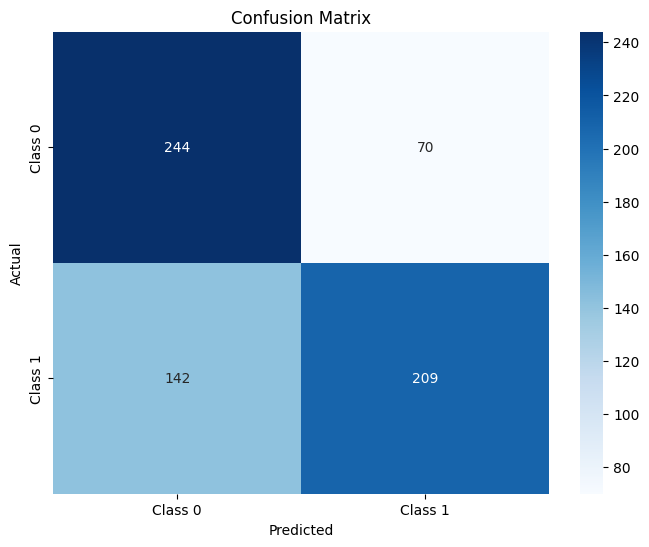

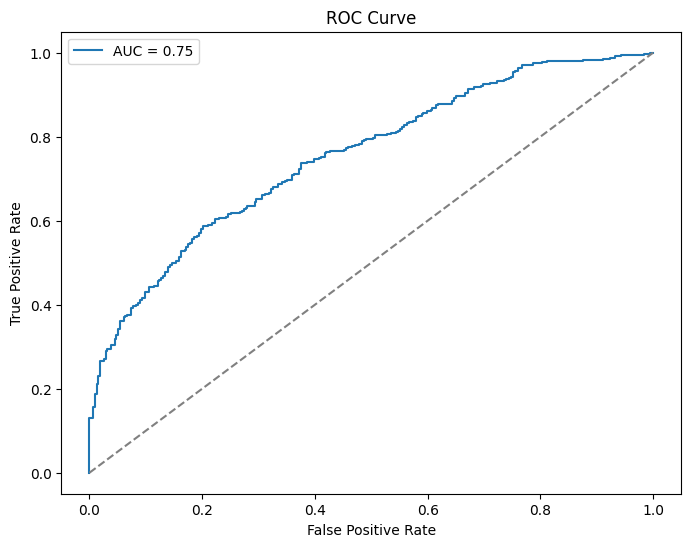

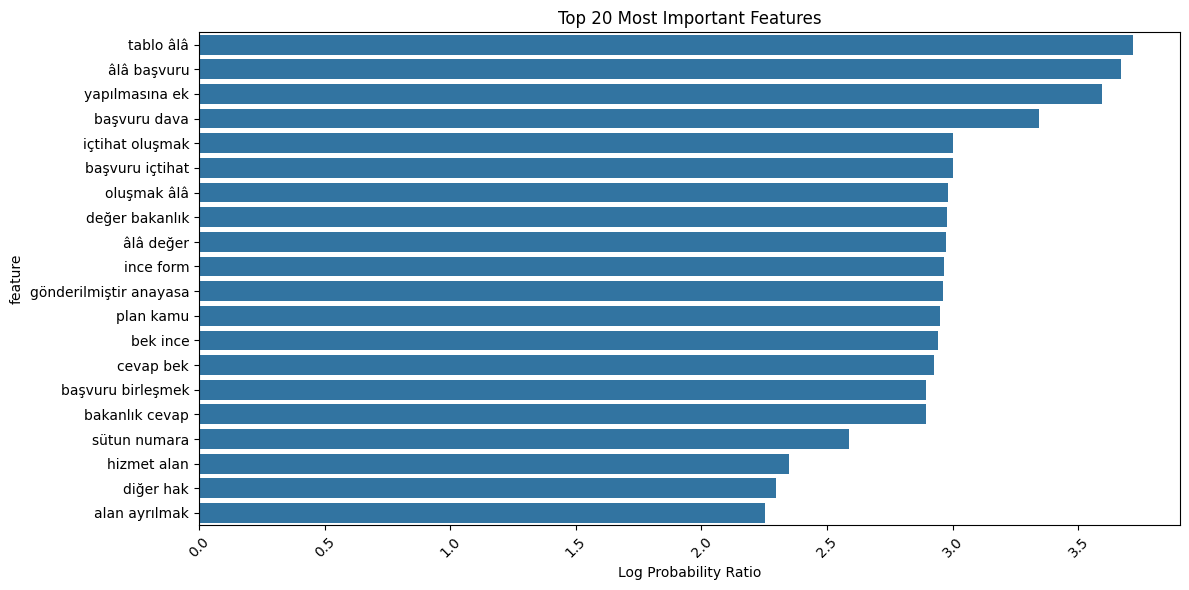

Accuracy: 0.68
Cross-Validation Scores: [0.66376238 0.67630745 0.67709984 0.6929477  0.68541997]
Mean CV Accuracy: 0.68
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.63      0.78      0.70       314
     Class 1       0.75      0.60      0.66       351

    accuracy                           0.68       665
   macro avg       0.69      0.69      0.68       665
weighted avg       0.69      0.68      0.68       665

ROC-AUC Score: 0.75

Top 10 Most Discriminative Features:
              feature  importance
3838        tablo âlâ    3.718453
4733      âlâ başvuru    3.670021
4438   yapılmasına ek    3.593059
461      başvuru dava    3.343160
2254  içtihat oluşmak    3.000981
466   başvuru içtihat    3.000774
3271      oluşmak âlâ    2.980471
1045   değer bakanlık    2.977118
4734        âlâ değer    2.974175
2129        ince form    2.966145


In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                           roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
def load_json_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return pd.DataFrame(json.load(file))

# Load datasets
# Load and prepare datasets
train_data = load_json_data('D:/Github Projects/Machine Learning in Law/Phase (2) - Data Processing & EDA/Preprocessed Data/training_dataset.json')
development_data = load_json_data('D:/Github Projects/Machine Learning in Law/Phase (2) - Data Processing & EDA/Preprocessed Data/development_dataset.json')
test_data = load_json_data('D:/Github Projects/Machine Learning in Law/Phase (2) - Data Processing & EDA/Preprocessed Data/testing_dataset.json')

# Extract features and labels for all datasets
def prepare_features_and_labels(data, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
        features = vectorizer.fit_transform(data['text'])
    else:
        features = vectorizer.transform(data['text'])
    labels = data['labels']
    return features, labels, vectorizer

# Prepare features and labels
X_train, y_train, vectorizer = prepare_features_and_labels(train_data)
X_dev, y_dev, _ = prepare_features_and_labels(development_data, vectorizer)
X_test, y_test, _ = prepare_features_and_labels(test_data, vectorizer)

# Combine training and development data for final model training
X_combined = np.vstack([X_train.toarray(), X_dev.toarray()])
y_combined = np.hstack([y_train, y_dev])

# Train Naive Bayes model
model = MultinomialNB()
model.fit(X_combined, y_combined)

# Model Evaluation
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions, target_names=['Class 0', 'Class 1'])
roc_auc = roc_auc_score(y_test, probabilities)

# Cross-Validation (for robustness)
cross_val_scores = cross_val_score(model, X_combined, y_combined, cv=5, scoring='accuracy')

# Feature Importance Analysis
feature_names = vectorizer.get_feature_names_out()
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_log_prob_[1] - model.feature_log_prob_[0]  # Log probability ratio
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualizations
# 1. Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 3. Top Features Plot
plt.figure(figsize=(12, 6))
top_features = feature_importance.head(20)
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('Top 20 Most Important Features')
plt.xlabel('Log Probability Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save processed datasets
train_data.to_json('processed_training_dataset.json', orient='records', force_ascii=False)
development_data.to_json('processed_development_dataset.json', orient='records', force_ascii=False)
test_data.to_json('processed_testing_dataset.json', orient='records', force_ascii=False)

# Save feature importance analysis
feature_importance.to_csv('feature_importance.csv', index=False)

# Performance Summary
print(f"Accuracy: {accuracy:.2f}")
print("Cross-Validation Scores:", cross_val_scores)
print(f"Mean CV Accuracy: {np.mean(cross_val_scores):.2f}")
print("Classification Report:\n", class_report)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Print top discriminative features
print("\nTop 10 Most Discriminative Features:")
print(feature_importance.head(10))